In [1]:
import pandas as pd
import numpy as np
import os
import lightgbm as lgb
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import json

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
class groupgby_dataset():
    def __init__(self,category = None,category_num = None,category_2nd = None,category_num_2nd = None):
        self.dir = '../features/'
        with open('../data/data_full.joblib', mode="rb") as f:
            self.data = joblib.load(f)
        self.idx = self.data[self.data[category] == category_num].index
        self.data = self.data.iloc[self.idx]
        
        if category_2nd != None:
            self.idx = self.data[self.data[category_2nd] == category_num_2nd].index
            self.data = self.data.iloc[self.idx]
        
        #weitht1, weight2, weight_mat_csr読み込み
        with open("../weight/weight1_" + category + "_"+ str(category_num) +".joblib", mode="rb") as f:
            self.weight1 = joblib.load(f)
        with open("../weight/weight2_" + category + "_"+ str(category_num) +".joblib", mode="rb") as f:
            self.weight2 = joblib.load(f)
        with open("../weight/weight_mat_csr_" + category + "_"+ str(category_num) +".joblib", mode="rb") as f:
            self.weight_mat_csr = joblib.load(f)
    
            
    def get_features(self,features = None ,path = None):

    #作成した特徴量の取得
        if features == None:
            print('features not selected')
            exit(0)
        else:
            dfs = []
            for feature in features:
                with open(path +'/'+ feature + '.joblib', mode="rb") as f:
                    tmp = joblib.load(f)
                    dfs.append(tmp.iloc[self.idx])
            tmp = pd.concat(dfs, axis=1)
            self.data = pd.concat([self.data,tmp],axis=1)

        return self.data
    
    def drop_features(self,features = None):
        self.data = self.data.drop(columns = features)
    
    def wrmsse(self,preds = None, data = None):
        NUM_ITEMS = 3049
        DAYS_PRED = 28
        # this function is calculate for last 28 days to consider the non-zero demand period

        # actual obserbed values / 正解ラベル
        y_true = data.get_label()

        y_true = y_true[-(NUM_ITEMS * DAYS_PRED):]
        preds = preds[-(NUM_ITEMS * DAYS_PRED):]
        # number of columns
        num_col = DAYS_PRED

        # reshape data to original array((NUM_ITEMS*num_col,1)->(NUM_ITEMS, num_col) ) / 推論の結果が 1 次元の配列になっているので直す
        reshaped_preds = np.array(preds).reshape(num_col, NUM_ITEMS).T
        reshaped_true = np.array(y_true).reshape(num_col, NUM_ITEMS).T


        train = self.weight_mat_csr*np.c_[reshaped_preds, reshaped_true]

        score = np.sum(
                    np.sqrt(
                        np.mean(
                            np.square(
                                train[:,:num_col] - train[:,num_col:])
                            ,axis=1) / self.weight1) * self.weight2)

        return 'wrmsse', score, False

In [18]:
class lightgbm():
    def __init__(self ,data):
        self.data = data
        
    def get_params(self,params):
        self.params = params
        
    def get_features(self , features):
        self.features = features
        
    def get_train_test(self):
        #self.data_train = self.data[(self.data['part'] == 'train') ]
        self.data_train = self.data[(self.data['part'] == 'train') ]
        #self.data_test = self.data[self.data['part'] == 'test2']
    
    
    def hold_out(self):
        END_TRAIN   = 1941               # End day of our train set
        P_HORIZON   = 28  
        self.get_train_test()
        x_val = self.data_train[self.data_train['d'] > (END_TRAIN-P_HORIZON)]
        y_val = self.data_train[self.data_train['d'] > (END_TRAIN-P_HORIZON)]['demand']
        x_train = self.data_train[self.data_train['d'] <= (END_TRAIN-P_HORIZON)] 
        y_train = self.data_train[self.data_train['d'] <= (END_TRAIN-P_HORIZON)]['demand']
        train_set = lgb.Dataset(x_train[self.features], y_train)
        val_set = lgb.Dataset(x_val[self.features], y_val)
        del x_val ,y_val ,x_train ,y_train
        return train_set , val_set
    

    def cv(self , cv_num):
        END_TRAIN   = 1941               # End day of our train set　　1941
        P_HORIZON   = cv_num
        self.get_train_test()
        x_val = self.data_train[(self.data_train['d'] > (END_TRAIN-P_HORIZON)) & (self.data_train['d'] <= (END_TRAIN-P_HORIZON + 28)) ]
        y_val = self.data_train[(self.data_train['d'] > (END_TRAIN-P_HORIZON)) & (self.data_train['d'] <= (END_TRAIN-P_HORIZON + 28)) ]['demand']
        x_train = self.data_train[self.data_train['d'] <= (END_TRAIN-P_HORIZON)] 
        y_train = self.data_train[self.data_train['d'] <= (END_TRAIN-P_HORIZON)]['demand']
        train_set = lgb.Dataset(x_train[self.features], y_train)
        val_set = lgb.Dataset(x_val[self.features], y_val)
        del x_val ,y_val ,x_train ,y_train
        return train_set , val_set
    
    
    def valid_fit(self,hold_out = None , model_name = 'sample', model_save = None ) :
        self.model_name = model_name
        if hold_out == True:
            
            train_set,val_set = self.hold_out()
            num_boost_round = 2500
            early_stopping_rounds = 50
            self.model = lgb.train(self.params, train_set, num_boost_round = num_boost_round, early_stopping_rounds = early_stopping_rounds, 
                  valid_sets = val_set, verbose_eval = 100, feval = data.wrmsse)
            

            
            self.best_score_ = self.model.best_score
            
            
            ##feature_importance
            self.feature_importances_ = self.model.feature_importance()
                                      
            fi_df = pd.DataFrame({'feature': self.features,'feature importance': self.feature_importances_}).sort_values('feature importance', ascending = False)
            plt.figure(figsize=(10,10))
            sns.barplot(fi_df['feature importance'],fi_df['feature'])
            plt.rcParams["font.size"] = 15
            plt.savefig('../logs/' + model_name + '_fi.png')
            
            
            ##config
            dictionary = {'features':self.features, 'params':self.params, 'cv':'hold_out' ,
              'num_boost_round':num_boost_round ,'early_stopping_rounds':early_stopping_rounds , 'num_trees':self.model.num_trees()}
            with open('../config/' + model_name +'.json' , 'w') as outfile:
                json.dump(dictionary, outfile)
                
                
            ##score(適当)
            with open('../logs/' + model_name + '.log', mode='w') as f:
                f.write(str(self.model.best_score))

            del train_set , val_set

        else:
            cv_scores = []
            num_trees = []
            cv_list = [28 ,56 , 84]
            for cv_num in cv_list:
                print('CV_{0} ~ {1}days'.format(1941 - cv_num , 1941 - cv_num + 28))
                train_set,val_set = self.cv(cv_num)
                num_boost_round = 2500
                early_stopping_rounds = 50
                self.model = lgb.train(self.params, train_set, num_boost_round = num_boost_round, early_stopping_rounds = early_stopping_rounds, 
                      valid_sets = val_set, verbose_eval = 100, feval = data.wrmsse)

                for i in self.model.best_score.values():
                    cv_scores.append(i['wrmsse'])
                num_trees.append(self.model.num_trees())

            for i in range(len(cv_scores)):
                print('CV{0}_WRMSSE_SCORE : {1}'.format(i+1 , cv_scores[i]))
            print('CV_mean_WRMSSE_SCORE : {0}'.format(np.mean(cv_scores)))
            ##score(CVの各スコアを保存)
            with open('../logs/' + model_name + '.log', mode='w') as f:
                f.write(str(cv_scores))


            ##config(predict用のモデルを作成する際にハイパラを利用するために保存、num_treesは各CVの平均としている)
            dictionary = {'features':self.features, 'params':self.params, 'cv':'hold_out' ,
              'num_boost_round':num_boost_round ,'early_stopping_rounds':early_stopping_rounds , 'num_trees':int(np.mean(num_trees)) , 'CV_mean_score':np.mean(cv_scores)}
            with open('../config/' + model_name +'.json' , 'w') as outfile:
                json.dump(dictionary, outfile)



##時系列のvalidationに使っていたデータも学習に回す
    def fit_for_predict(self , valid_name =None):

      num_boost_round = 350
      self.params['n_estimators'] = 350

      #train_data作成、test1の正解追加後に変更必須
      data_train = self.data[self.data['part'] == 'train']
      train_set = lgb.Dataset(data_train[self.features], data_train['demand'])
      self.model = lgb.train(self.params, train_set, num_boost_round = num_boost_round)

      filename =  '../Model/'+ valid_name  + '.joblib'
      joblib.dump(self.model, filename)


    def load_model(self , store , day):
      with open('../Model/' + 'store{0} _day{1}'.format(store , day) + '.joblib', mode="rb") as f:
          self.model = joblib.load(f)
            


##再帰モデルのまま    
    def predict(self, day , store,part = 'test2'):
        self.load_model(store = store , day = day)
        tmp = self.model.predict(self.data[(self.data['d'] ==1942 + int(day) -1) & (self.data['store_id'] ==int(store))][self.features])

        self.data.loc[self.data[(self.data['d'] ==1942 + int(day) -1) & (self.data['store_id'] ==int(store))].index , 'demand'] = tmp
        predict_df = self.data.loc[self.data[(self.data['d'] ==1942 + int(day) -1) & (self.data['store_id'] ==int(store))].index , ['d' , 'id','demand']]

        filename =  '../predict/'+ 'store{0}_day{1}'.format(store , day)  + '.joblib'
        joblib.dump(predict_df, filename)
        

In [ ]:
data = groupgby_dataset(category='store_id' , category_num= 10)


##特徴量選択例
path = '../features/SNAP_Feature'
SNAP_lag_features = ['Lag_SNAP_CA']
data.get_features(features=SNAP_lag_features , path = path)

In [ ]:
########################### Model params
lgb_params = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'custom',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.03,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 1400,
                    'boost_from_average': False,
                    'verbose': -1,
                } 

In [ ]:
########################### features

base_features = [ "item_id","dept_id","cat_id","event_name_1","event_type_1","event_name_2","event_type_2", "snap_CA","sell_price"]
#Ordered_TS_features = [ 'Ordered_TS_cat_shift1' , 'Ordered_TS_dept_shift1' , 'Ordered_TS_id_price']

#price_feature = ['rolling_price_mean_t7'	,'rolling_price_mean_t28'	,'rolling_price_mean_t56',	'rolling_price_mean_t84'	,'rolling_price_mean_t168'	,
 #                'rolling_price_std_t7'	,'rolling_price_std_t28'	,'rolling_price_std_t56'	,'rolling_price_std_t84'	,'rolling_price_std_t168'	,
  #               'price_max' ,'price_min'  ,'price_mean' ,'price_norm' ,'cnt_price_change' ,'price_change_lag']


features = base_features + SNAP_lag_features + calendar_feature + price_feature + Ordered_TS_features  +demand_lag_features + etc_feature+ demand_probability_feature + wavelet_lag_Feature_shiftX

In [ ]:
###features(相関の高い特徴量を消す)

counter = 0
to_remove = []
for feat_a in features:
    for feat_b in features:
        if feat_a != feat_b and feat_a not in to_remove and feat_b not in to_remove:
            c = np.corrcoef(data.data[feat_a], data.data[feat_b])[0][1]
            if c > 0.995:
                counter += 1
                to_remove.append(feat_b)
                print('{}: FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(counter, feat_a, feat_b, c))

In [ ]:
data = groupgby_dataset(category='store_id' , category_num= 0)
path = '../features/SNAP_Feature'
data.get_features(features=os.listdir(path) , path = path)

In [19]:
lgb_clf = lightgbm(data = data.data)
del data
lgb_clf.get_params(params=lgb_params)
lgb_clf.get_features(features=features)

In [20]:
lgb_clf.get_params(params=lgb_params)
lgb_clf.get_features(features=features)

Training until validation scores don't improve for 1 rounds
Early stopping, best iteration is:
[86]	valid_0's rmse: 3.14636


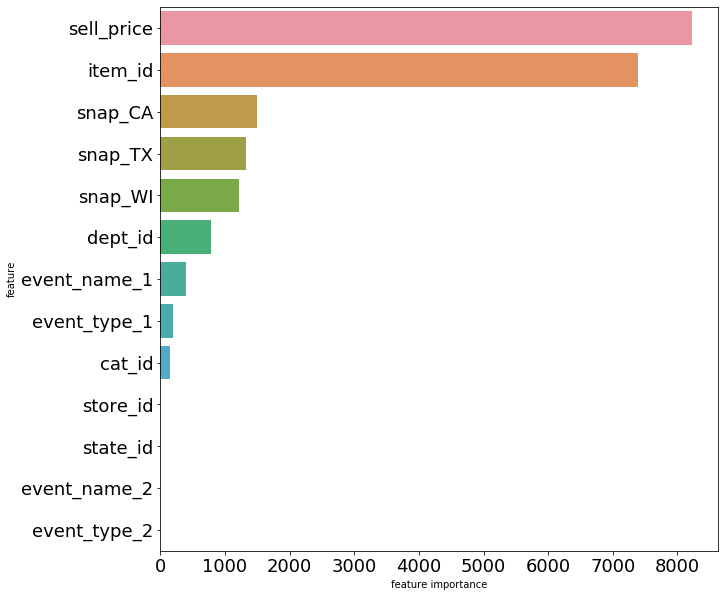

In [21]:
lgb_clf.valid_fit(model_name = 'sample0624_best_add_wavelet' ,model_save=False , hold_out = False)